<a href="https://colab.research.google.com/github/pwguimar/Squad04-Semantic-Segmentation-Drone-Dataset/blob/main/Sq04_atividade01_062025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Segmentação de Imagens Urbanas
## Bootcamp Machine Learning - Atlântico Avanti: 06/2025.

Neste primeira etapa, o trabalho avaliou o dataset "Semantic Segmentation Drone Dataset" e teve como foco principal a análise exploratória dos dados disponíveis.

**Objetivo**: apresentar informações iniciais sobre as características do dataset.

**Integrantes**:

- Felipe Ferreira Dos Santos
- Hozana Izadora Da Silva Ferreira
- Patrick Wohrle Guimaraes
- Sarah Cavalcante Salvino

**Dataset disponível em**: [Kaggle]( https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset?select=Image)

## 📚 Instalações, montar drive (Gdrive), importar Bibliotecas e  leitura dataset

In [2]:
# Instalação de bibliotecas necessárias
!pip install pandas numpy matplotlib Pillow opencv-python imagehash tqdm tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.5 MB/s eta 0:00:00


In [3]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import imagehash
import ast
import json
from collections import Counter
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
from itertools import combinations
from pathlib import Path


# Definição dos caminhos para o dataset no Google Drive
# AJUSTE ESTES CAMINHOS para onde você salvou o dataset no SEU Google Drive
# Exemplo: se você salvou o conteúdo da pasta 'semantic-segmentation-drone-dataset'
# dentro de 'Meu Drive/datasets/semantic-segmentation-drone-dataset'
BASE_DIR = "/content/drive/MyDrive/dataset"
IMAGE_DIR = os.path.join(BASE_DIR, "binary_dataset/binary_dataset/original_images/")
MASK_DIR = os.path.join(BASE_DIR, "binary_dataset/binary_dataset/images_semantic/")

# Verificar se os diretórios existem
if not os.path.exists(IMAGE_DIR):
    print(f"ERRO: Diretório de imagens não encontrado em {IMAGE_DIR}")
    print("Por favor, ajuste o caminho IMAGE_DIR para o local correto no seu Google Drive.")
if not os.path.exists(MASK_DIR):
    print(f"ERRO: Diretório de máscaras não encontrado em {MASK_DIR}")
    print("Por favor, ajuste o caminho MASK_DIR para o local correto no seu Google Drive.")

# Lista de arquivos nos diretórios
# Use um bloco try-except caso os diretórios não existam (devido a caminhos incorretos)
try:
    image_files = sorted([f for f in os.listdir(IMAGE_DIR) if os.path.isfile(os.path.join(IMAGE_DIR, f))])
    mask_files = sorted([f for f in os.listdir(MASK_DIR) if os.path.isfile(os.path.join(MASK_DIR, f))])

    print(f"Total de imagens encontradas: {len(image_files)}")
    print(f"Total de máscaras encontradas: {len(mask_files)}")

except FileNotFoundError:
    print("\nNão foi possível listar os arquivos. Verifique se os caminhos IMAGE_DIR e MASK_DIR estão corretos.")
    image_files = [] # Definir como lista vazia para evitar erros nos próximos passos
    mask_files = []

Total de imagens encontradas: 400
Total de máscaras encontradas: 400


# Integridade dos Arquivos

In [5]:
#import os

# Montar o Google Drive (execute esta célula no Colab antes de rodar o resto)
#from google.colab import drive
#drive.mount('/content/drive')

# Defina os caminhos com base no seu Google Drive
#BASE_DIR = "/content/drive/MyDrive/dataset" # This is correct, points to MyDrive/dataset

# Correção aqui: remova o "dataset/" extra
#IMAGE_DIR = os.path.join(BASE_DIR, "original_images/")
#MASK_DIR = os.path.join(BASE_DIR, "images_semantic/")
#IMAGE_DIR = os.path.join(BASE_DIR, "binary_dataset/binary_dataset/original_images/")
#MASK_DIR = os.path.join(BASE_DIR, "binary_dataset/binary_dataset/images_semantic/")

# Esta função verifica:
# 1. Se os arquivos das duas pastas têm o mesmo formato (ex: .png)
# 2. Se os arquivos têm os mesmos nomes (ignorando a extensão)
def verificar_imagens(original_dir, semantic_dir):
    resultados = []

    def obter_info_diretorio(pasta):
        # Listar apenas arquivos, ignorando subdiretórios
        arquivos = [f for f in os.listdir(pasta) if os.path.isfile(os.path.join(pasta, f))]
        extensoes = {os.path.splitext(f)[-1].lower() for f in arquivos}
        nomes_base = {os.path.splitext(f)[0] for f in arquivos}
        return arquivos, extensoes, nomes_base

    try:
        arquivos_ori, ext_ori, nomes_ori = obter_info_diretorio(original_dir)
        arquivos_sem, ext_sem, nomes_sem = obter_info_diretorio(semantic_dir)
    except FileNotFoundError as e:
        return [f"❌ Erro ao acessar as pastas: {e}"]
    except Exception as e: # Catch other potential errors during listing
        return [f"❌ Ocorreu um erro inesperado ao processar os diretórios: {e}"]


    if len(ext_ori) == 1:
        resultados.append(f"✅ original_images: todas as imagens estão no formato {list(ext_ori)[0]}")
    else:
        resultados.append("⚠️ original_images contém múltiplos formatos:")
        resultados.extend([f"   - {ext}" for ext in sorted(ext_ori)])

    if len(ext_sem) == 1:
        resultados.append(f"✅ images_semantic: todas as imagens estão no formato {list(ext_sem)[0]}")
    else:
        resultados.append("⚠️ images_semantic contém múltiplos formatos:")
        resultados.extend([f"   - {ext}" for ext in sorted(ext_sem)])

    if nomes_ori == nomes_sem:
        resultados.append("✅ As duas pastas possuem os mesmos nomes de arquivos (sem extensão).")
    else:
        # Sort these sets to ensure consistent output order
        faltando_em_sem = sorted(nomes_ori - nomes_sem)
        faltando_em_ori = sorted(nomes_sem - nomes_ori)

        resultados.append("⚠️ Diferenças entre os nomes de arquivos encontrados:")
        if faltando_em_sem:
            resultados.append("   - Presentes em original_images, mas faltando em images_semantic:")
            resultados.extend([f"     - {nome}" for nome in faltando_em_sem])
        if faltando_em_ori:
            resultados.append("   - Presentes em images_semantic, mas faltando em original_images:")
            resultados.extend([f"     - {nome}" for nome in faltando_em_ori])

    return resultados

# Executa a verificação e imprime os resultados
print("\n📋 Resultados da verificação:\n")
for linha in verificar_imagens(IMAGE_DIR, MASK_DIR):
    print(linha)


📋 Resultados da verificação:

✅ original_images: todas as imagens estão no formato .png
✅ images_semantic: todas as imagens estão no formato .png
✅ As duas pastas possuem os mesmos nomes de arquivos (sem extensão).


# Consistência dos Metadados

* **Verifique se há valores ausentes nos metadados e como esses casos são tratados.**

* **Verifique valores inconsistentes, por exemplo: dimensões de imagens fora do esperado**


In [6]:

CSV_PATH = r"/content/metadata_binario.csv"
VALORES_INVALIDOS = {"", "N/A", "None", "[]", "{}", "nan", "NaN", "n/a", "null"}

CLASSES_BINARIAS = {
    0: {0, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},  # background
    1: {1, 2, 3, 4, 9}  # objeto
}

# Função para formatar porcentagens de acordo com as faixas de pixels
# de background e objeto
def formatar_porcentagem(valor):
    if valor == 0:
        return "0%"
    elif valor < 0.01:
        return "<1%"
    elif valor < 0.1:
        return "1-10%"
    elif valor < 0.25:
        return "10-25%"
    elif valor < 0.5:
        return "25-50%"
    elif valor < 0.75:
        return "50-75%"
    else:
        return ">75%"

def verificar_metadados(csv_path):
    if not os.path.exists(csv_path):
        print(f"[ERRO] Arquivo não encontrado: {csv_path}")
        return

    df = pd.read_csv(csv_path)
    total_imagens = len(df)
    print(f"\nℹ️ Total de imagens no dataset: {total_imagens:,}")

    print("\n 1. Valores ausentes ou inválidos:")
    print("-" * 50)
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0]

    if nulos.empty:
        print(" Nenhum valor ausente (NaN) encontrado.")
    else:
        print(" Valores ausentes encontrados:")
        print(tabulate(nulos.reset_index().rename(columns={"index": "Coluna", 0: "Total NaN"}), headers="keys", tablefmt="pretty"))

    simbolicos_invalidos = []
    for col in df.columns:
        count = df[col].astype(str).isin(VALORES_INVALIDOS).sum()
        if count > 0:
            simbolicos_invalidos.append((col, count))

    if not simbolicos_invalidos:
        print(" Nenhum valor simbólico inválido encontrado.")
    else:
        print("\n Valores simbólicos inválidos encontrados:")
        print(tabulate(simbolicos_invalidos, headers=["Coluna", "Quantidade"], tablefmt="pretty"))

    print("\n 2. Dimensões das imagens:")
    print("-" * 50)
    retangulares = df[df["largura"] != df["altura"]]
    if retangulares.empty:
        print(" Todas as imagens são quadradas (largura = altura).")
    else:
        primeiro = retangulares.iloc[0]
        print(f"  {len(retangulares)} imagens retangulares encontradas.")
        print(f"  Exemplo: arquivo={primeiro['arquivo']}, largura={primeiro['largura']}, altura={primeiro['altura']}")


    print("\n 3. Consistência dos dados de pixels:")
    print("-" * 50)
    df["soma_pixels"] = df["pixels_background"] + df["pixels_objeto"]
    inconsistencias = df[df["soma_pixels"] != df["total_pixels"]]

    if inconsistencias.empty:
        print(" Todas as imagens têm soma de pixels (background + objeto) igual ao total.")
    else:
        print(f" {len(inconsistencias)} imagens com soma de pixels inconsistente:")
        print(tabulate(inconsistencias[["arquivo", "pixels_background", "pixels_objeto", "total_pixels"]].head(), headers="keys", tablefmt="pretty"))

    df["soma_proporcao"] = df["proporcao_background"] + df["proporcao_objeto"]
    proporcoes_inconsistentes = df[abs(df["soma_proporcao"] - 1.0) > 0.01]
    if proporcoes_inconsistentes.empty:
        print(" Todas as imagens têm proporções que somam aproximadamente 1.0.")
    else:
        print(f" {len(proporcoes_inconsistentes)} imagens com proporções inconsistentes:")
        print(tabulate(proporcoes_inconsistentes[["arquivo", "proporcao_background", "proporcao_objeto", "soma_proporcao"]].head(), headers="keys", tablefmt="pretty"))

    print("\n 4. Verificação das faixas de porcentagem:")
    print("-" * 50)
    df["faixa_calculada"] = df["proporcao_objeto"].apply(formatar_porcentagem)
    faixas_incorretas = df[df["faixa_proporcao_objeto"] != df["faixa_calculada"]]
    if faixas_incorretas.empty:
        print(" Todas as faixas de porcentagem estão corretamente calculadas.")
    else:
        print(f" {len(faixas_incorretas)} imagens com faixas de porcentagem incorretas:")
        print(tabulate(faixas_incorretas[["arquivo", "proporcao_objeto", "faixa_proporcao_objeto", "faixa_calculada"]].head(), headers="keys", tablefmt="pretty"))

        # 5. Análise binária: presença de fundo e objeto
    print("\n 5. Análise binária (com base em background e objeto):")
    print("-" * 50)

    if {"somente_background", "somente_objeto", "background_e_objeto"}.issubset(df.columns):
        total = len(df)
        apenas_bg = df["somente_background"].sum()
        apenas_obj = df["somente_objeto"].sum()
        ambos = df["background_e_objeto"].sum()

        print(f" Imagens com apenas background: {apenas_bg} ({apenas_bg / total:.1%})")
        print(f" Imagens com apenas objeto: {apenas_obj} ({apenas_obj / total:.1%})")
        print(f" Imagens com background e objeto: {ambos} ({ambos / total:.1%})")

        if apenas_bg > 0:
            print("  Algumas imagens não têm nenhum pixel de objeto — podem ser irrelevantes para o modelo.")
        if apenas_obj > 0:
            print("  Algumas imagens têm apenas objeto — verifique se o fundo foi corretamente identificado como classe 0.")
    else:
        print(" As colunas 'somente_background', 'somente_objeto', 'background_e_objeto' não estão presentes no CSV.")
        print("Sem elas, não é possível avaliar a presença dos grupos binários nas máscaras.")


    print("\n" + "=" * 60)
    print(" RESUMO FINAL DA QUALIDADE DOS METADADOS")
    print("=" * 60)

    problemas = []
    if not nulos.empty:
        problemas.append(f"• Valores ausentes (NaN) em {len(nulos)} coluna(s)")
    if simbolicos_invalidos:
        problemas.append(f"• Valores simbólicos inválidos em {len(simbolicos_invalidos)} coluna(s)")
    if not retangulares.empty:
        problemas.append(f"• {len(retangulares)} imagens retangulares (largura ≠ altura)")
    if not inconsistencias.empty:
        problemas.append(f"• {len(inconsistencias)} imagens com soma de pixels inconsistente")
    if not proporcoes_inconsistentes.empty:
        problemas.append(f"• {len(proporcoes_inconsistentes)} imagens com proporções inconsistentes")
    if not faixas_incorretas.empty:
        problemas.append(f"• {len(faixas_incorretas)} imagens com faixas de porcentagem incorretas")
    if 'classes_presentes' in df.columns and classes_nao_mapeadas:
        problemas.append(f"• {len(classes_nao_mapeadas)} classe(s) não mapeadas no agrupamento binário")

    if problemas:
        print("\n PROBLEMAS ENCONTRADOS:")
        for problema in problemas:
            print(problema)
    else:
        print("\n METADADOS CONSISTENTES: Nenhum problema grave encontrado!")
        print("O dataset parece estar bem preparado para uso em modelos de segmentação semântica.")

if __name__ == "__main__":
    verificar_metadados(CSV_PATH)




ℹ️ Total de imagens no dataset: 400

 1. Valores ausentes ou inválidos:
--------------------------------------------------
 Nenhum valor ausente (NaN) encontrado.
 Nenhum valor simbólico inválido encontrado.

 2. Dimensões das imagens:
--------------------------------------------------
  400 imagens retangulares encontradas.
  Exemplo: arquivo=000.png, largura=960, altura=736

 3. Consistência dos dados de pixels:
--------------------------------------------------
 Todas as imagens têm soma de pixels (background + objeto) igual ao total.
 Todas as imagens têm proporções que somam aproximadamente 1.0.

 4. Verificação das faixas de porcentagem:
--------------------------------------------------
 Todas as faixas de porcentagem estão corretamente calculadas.

 5. Análise binária (com base em background e objeto):
--------------------------------------------------
 Imagens com apenas background: 0 (0.0%)
 Imagens com apenas objeto: 0 (0.0%)
 Imagens com background e objeto: 400 (100.0%)



Embora os metadados estejam íntegros e sem valores ausentes, sem erros de soma de pixels ou de proporções e com todas as faixas corretamente calculadas, há um ponto crítico: todas as 400 imagens são retangulares (960 × 736 no exemplo).

E idealmente deveríamos trabalhar com formatos quadrados para manter a proporção dos pixels em tarefas de segmentação semântica.

Esse desvio pode afetar a performance de modelos que esperam entradas quadradas, portanto, uma solução seria redimensionar ou recortar as máscaras para um formato uniforme.




---



# Qualidade das Imagens (Identificar Imagens Corrompidas)
- Objetivo: Identificar imagens (e máscaras) que não podem ser abertas ou processadas, indicando corrupção.

In [7]:
import os
from PIL import Image
# Removida a importação de tqdm

def check_corrupted_files(directory, filenames, file_type):
    """
    Verifica se os arquivos em um diretório específico estão corrompidos
    tentando abri-los e verificando sua integridade usando Pillow.

    Args:
        directory (str): O caminho para o diretório contendo os arquivos.
        filenames (list): Uma lista de nomes de arquivos a serem verificados.
        file_type (str): Um nome descritivo para o tipo de arquivo (ex: 'imagens', 'máscaras').

    Returns:
        list: Uma lista de tuplas, onde cada tupla contém o nome do arquivo
              corrompido e a mensagem de erro capturada.
    """
    corrupted_list = []
    print(f"\nVerificando {file_type} corrompidas...")

    total_files = len(filenames)
    if total_files == 0:
        print(f"Nenhum arquivo {file_type} encontrado para verificar.")
        return []

    # Define um intervalo para imprimir o progresso (ex: a cada 10% ou 50 arquivos)
    # Garante que o intervalo seja pelo menos 1
    print_interval = max(1, min(total_files // 10, 50))

    for i, filename in enumerate(filenames):
        filepath = os.path.join(directory, filename)

        # Imprime uma mensagem de progresso em intervalos definidos
        if (i + 1) % print_interval == 0 or (i + 1) == total_files:
            print(f"  Processados {i + 1}/{total_files} arquivos {file_type}...")

        try:
            # Abre a imagem e verifica sua integridade sem carregar todos os dados
            with Image.open(filepath) as img:
                img.verify()
        except Exception as e:
            # Captura qualquer erro durante a abertura ou verificação
            corrupted_list.append((filename, str(e)))

    print(f"Verificação de {file_type} completa.")

    return corrupted_list

# --- Início do Algoritmo Principal ---
# Assume que 'image_files' e 'mask_files' são listas de nomes de arquivos
# e 'IMAGE_DIR' e 'MASK_DIR' são os caminhos para os diretórios,
# definidos ANTES deste bloco.

if 'image_files' in locals() and 'mask_files' in locals() and image_files and mask_files:
    # Chama a função para verificar imagens e máscaras
    corrupted_images = check_corrupted_files(IMAGE_DIR, image_files, 'imagens')
    corrupted_masks = check_corrupted_files(MASK_DIR, mask_files, 'máscaras')

    # --- Relatório dos Resultados ---
    if not corrupted_images:
        print("Verificação de Qualidade: Nenhuma imagem corrompida encontrada.")
    else:
        print(f"Verificação de Qualidade: {len(corrupted_images)} imagens corrompidas encontradas.")
        # Exemplo de como imprimir os arquivos corrompidos (opcional)
        # print(" Exemplos (arquivo, erro):")
        # for item in corrupted_images[:10]:
        #     print(f"  {item[0]}: {item[1]}")

    if not corrupted_masks:
        print("Verificação de Qualidade: Nenhuma máscara corrompida encontrada.")
    else:
        print(f"Verificação de Qualidade: {len(corrupted_masks)} máscaras corrompidas encontradas.")
        # Exemplo de como imprimir os arquivos corrompidos (opcional)
        # print(" Exemplos (arquivo, erro):")
        # for item in corrupted_masks[:10]:
        #     print(f"  {item[0]}: {item[1]}")
else:
    # Executado se as listas de arquivos estiverem vazias ou não definidas
    print("\nPulando Verificação de Qualidade: Listas de arquivos de imagem/máscara vazias ou não definidas.")
    print("Verifique se IMAGE_DIR e MASK_DIR estão definidos corretamente e contêm arquivos.")



Verificando imagens corrompidas...
  Processados 40/400 arquivos imagens...
  Processados 80/400 arquivos imagens...
  Processados 120/400 arquivos imagens...
  Processados 160/400 arquivos imagens...
  Processados 200/400 arquivos imagens...
  Processados 240/400 arquivos imagens...
  Processados 280/400 arquivos imagens...
  Processados 320/400 arquivos imagens...
  Processados 360/400 arquivos imagens...
  Processados 400/400 arquivos imagens...
Verificação de imagens completa.

Verificando máscaras corrompidas...
  Processados 40/400 arquivos máscaras...
  Processados 80/400 arquivos máscaras...
  Processados 120/400 arquivos máscaras...
  Processados 160/400 arquivos máscaras...
  Processados 200/400 arquivos máscaras...
  Processados 240/400 arquivos máscaras...
  Processados 280/400 arquivos máscaras...
  Processados 320/400 arquivos máscaras...
  Processados 360/400 arquivos máscaras...
  Processados 400/400 arquivos máscaras...
Verificação de máscaras completa.
Verificação de

# Distribuição das Classes
##### Objetivo: Verificar a distribuição das classes para identificar possíveis desequilíbrios que possam afetar a modelagem



Valores únicos após remapeamento: [0 1]
obstacles: 68908231 pixels (24.38%)
landing-zones: 213715769 pixels (75.62%)


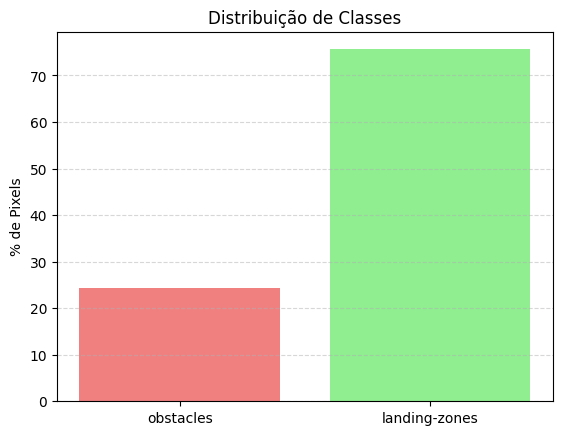

In [8]:
# Parâmetros
binary_masks_dir = MASK_DIR
rgb_to_binary_id = {
    (204, 153, 255): 0,  # obstacles
    (0, 153, 153): 1     # landing-zones
}
binary_id_to_name = {
    0: 'obstacles',
    1: 'landing-zones'
}

# Verifica máscaras
mask_files = [f for f in os.listdir(binary_masks_dir) if f.lower().endswith((".png", ".jpg"))]
if not mask_files:
    print("Nenhuma imagem encontrada.")
    exit()

# Contagem de pixels
pixel_counts = {name: 0 for name in binary_id_to_name.values()}
for i, fname in enumerate(mask_files):
    img = cv2.cvtColor(cv2.imread(os.path.join(binary_masks_dir, fname)), cv2.COLOR_BGR2RGB)
    mask = np.full(img.shape[:2], 255, np.uint8)

    for rgb, val in rgb_to_binary_id.items():
        match = np.all(np.abs(img - rgb) <= 1, axis=2)
        mask[match] = val

    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        if u != 255 and u in binary_id_to_name:
            pixel_counts[binary_id_to_name[u]] += c

    if i == 0:
        print("Valores únicos após remapeamento:", np.unique(mask))

# Distribuição
total = sum(pixel_counts.values())
for cls, count in pixel_counts.items():
    perc = (count / total) * 100 if total else 0
    print(f"{cls}: {count} pixels ({perc:.2f}%)")

# Gráfico
plt.bar(pixel_counts.keys(), [v / total * 100 for v in pixel_counts.values()], color=['lightcoral', 'lightgreen'])
plt.ylabel('% de Pixels')
plt.title('Distribuição de Classes')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

Saída:
```
Valores únicos após remapeamento: [0 1]
obstacles: 68908231 pixels (24.38%)
landing-zones: 213715769 pixels (75.62%)
```
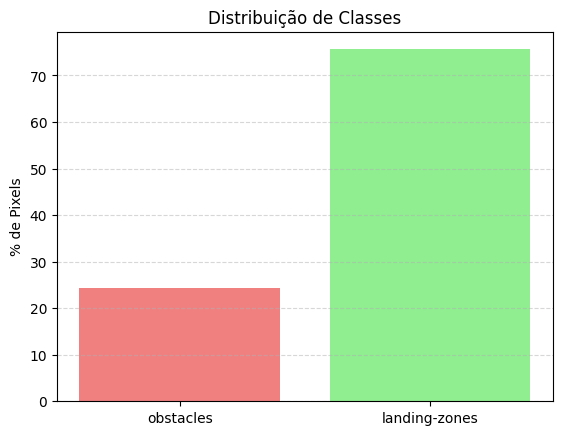

Análise:
O dataset apresenta um desequilíbrio significativo entre as classes binárias. A classe landing-zones (75.62%) é a classe majoritária, enquanto a classe obstacles (24.38%) é a classe minoritária. A proporção é de aproximadamente 3:1 (três vezes mais pixels de landing-zones do que de obstacles).
Embora a classe obstacles esteja acima do limiar de 2.0% para ser considerada "minoritária crítica" neste caso, um desequilíbrio de 3:1 ainda pode introduzir viés no modelo se não for tratado.

# *Duplicatas*

■ Identifique imagens duplicadas que possam enviesar os resultados.  
■ Verifique duplicatas no arquivo de informações.



In [9]:
# Caminho da pasta
caminho_pasta = Path("binary_dataset/binary_dataset/images_semantic/")

# Tamanho fixo para padronizar
tamanho_padrao = (256, 256)

# Carrega todas as imagens .png
imagens = list(caminho_pasta.glob("*.png"))
imagens_dict = {}

# Carrega e padroniza
for caminho in imagens:
    img = cv2.imread(str(caminho), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_padronizada = cv2.resize(img, tamanho_padrao)
        imagens_dict[caminho.name] = img_padronizada

# Comparar pixel a pixel
print(" Verificando imagens exatamente iguais:\n")
iguais = False
for (nome1, img1), (nome2, img2) in combinations(imagens_dict.items(), 2):
    if np.array_equal(img1, img2):
        print(f"🟥 Iguais: {nome1} == {nome2}")
        iguais = True

if not iguais:
    print("✅ Nenhuma imagem exatamente igual encontrada.")

 Verificando imagens exatamente iguais:

✅ Nenhuma imagem exatamente igual encontrada.
